In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 268 ('font.family         : sans-serif        ')
Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 272 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')


In [3]:
def feature_label_generator(raw_data, window_size=16):
    """
    description:
        输入时间序列，根据时间系列生成样本（特征和标签）
    parameters:
        raw_data: 原始时间序列
        Window_size: 滑动窗口长度
    returns:
        features: 生成的特征集合
        labels: 生成的标签集合
    """
    raw_data = np.array(raw_data) if type(raw_data) is not np.ndarray else raw_data
    features, labels = [], []
    for i in range(len(raw_data) - window_size):
        features.append(raw_data[i:i + window_size])
        labels.append(raw_data[i + window_size])
    return features, labels

test_raw_data = np.array(range(128))
features, labels = feature_label_generator(test_raw_data, window_size=28)
print(len(features), features)
print(len(labels), labels)

100 [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]), array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]), array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]), array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 2

<class 'dict'> 4
dict_keys(['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38'])


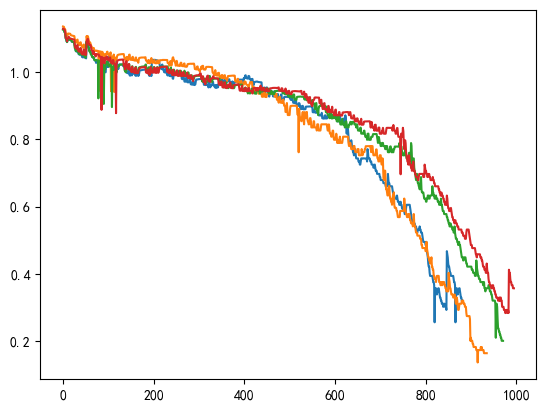

In [4]:
# 数据导入
dataset_path = "./data/calce/CALCE.npy"
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery = np.load(dataset_path, allow_pickle=True)
Battery = Battery.item()

calce_dataset = {}

print(type(Battery), len(Battery)) # dict, 4（四块电芯）
print(Battery.keys()) # dict_keys(['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38'])
for cell in Battery.keys():
    # print(type(Battery[cell]), len(Battery[cell])) # Battery[cell]是一张dataframe
    calce_dataset[cell] = list(Battery[cell]["capacity"])
    # print(len(calce_dataset[cell])) # 882, 936, 972, 996
    plt.plot(calce_dataset[cell])

In [5]:
class CALCEDataset(Dataset):
    def __init__(self, data, train, window_size):
        self.data = data
        self.mode = "train" if train else "test"
        self.input, self.output = feature_label_generator(raw_data=self.data, window_size=window_size)
 
    def __len__(self):
        assert len(self.input) == len(self.output), f"shape doesn't match: {self.input}, {self.output}"
        return len(self.input)
    
    def __getitem__(self, index):
        input = torch.FloatTensor(self.input[index]).reshape(1, 16)
        output = np.float32(self.output[index])
        return input, output
    
class BatteryDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        sequence, target = self.data[index]
        return sequence, target
    
# window_size = 5
# train = list(range(10))
# test = list(range(10, 20))
# train = train + test[:window_size]
# print(train)
# print(test)
# train_dataset = feature_label_generator(train, window_size=window_size)
# test_dataset = feature_label_generator(test, window_size=window_size)
# print("+++")
# print(train_dataset)
# print(test_dataset)
# print("+++")
# print()

# train_dataset = CALCEDataset(data=train, train=True, window_size=window_size)
# test_dataset = CALCEDataset(data=test, train=False, window_size=window_size)
# print("+++")
# print(list(train_dataset)[-1])
# print(list(test_dataset)[0])
# print("+++")

window_size = 16
b35 = list(CALCEDataset(calce_dataset["CS2_35"], train=True, window_size=window_size))
b36 = list(CALCEDataset(calce_dataset["CS2_36"], train=True, window_size=window_size))
b37 = list(CALCEDataset(calce_dataset["CS2_37"], train=True, window_size=window_size))
b38 = list(CALCEDataset(calce_dataset["CS2_38"], train=True, window_size=window_size))

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

class TSCNN(nn.Module):
    def __init__(self):
        super(TSCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2)
        self.relu = nn.LeakyReLU(negative_slope=0.1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2)
        self.fc1 = nn.Linear(32 * 14, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        batch_size= x.size(0)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
model = TSCNN().to(device)
print(model)
print(summary(model, (1, 16)))

using device: cuda
TSCNN(
  (conv1): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (relu): LeakyReLU(negative_slope=0.1)
  (conv2): Conv1d(64, 32, kernel_size=(2,), stride=(1,))
  (fc1): Linear(in_features=448, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 15]             192
         LeakyReLU-2               [-1, 64, 15]               0
            Conv1d-3               [-1, 32, 14]           4,128
         LeakyReLU-4               [-1, 32, 14]               0
            Linear-5                   [-1, 50]          22,450
            Linear-6                    [-1, 1]              51
Total params: 26,821
Trainable params: 26,821
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (M

In [7]:
model = TSCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
batch_size = 16
epochs = 400

def train(model, train_dataloader, loss_fn, optimizer, epoch):
    model.train()
    for idx, (X, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device).reshape(-1, 1)
        pred = model(X)
        loss = loss_fn(y, pred)
        loss.backward()
        optimizer.step()

训练开始
训练完成


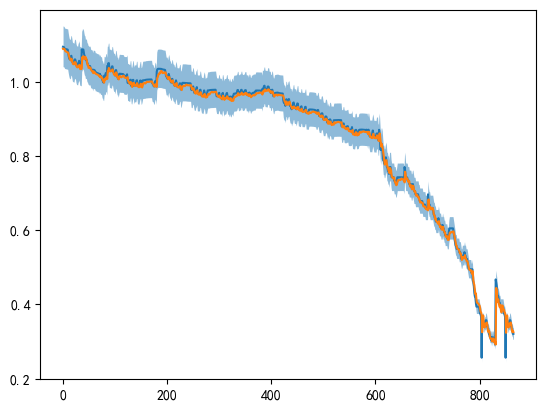

In [8]:
# b35为测试集合

train_dataset = BatteryDataset(b36 + b37 + b38)
test_dataset = BatteryDataset(b35)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("训练开始")
for epoch in range(epochs):
    train(model, train_dataloader, criterion, optimizer, epoch)
print("训练完成")

y_pred, gt, y1, y2 = [], [], [], []
cycle = [i + 1 for i in range(len(test_dataset))]
model.eval()
for idx, (X, y) in enumerate(test_dataset):
    X = X.to(device)
    y_pred.append(float(model(X)))
    gt.append(y)
    y1.append(y * (1 + 0.05))
    y2.append(y * (1 - 0.05))

plt.plot(gt)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(y_pred)

训练开始
训练完成


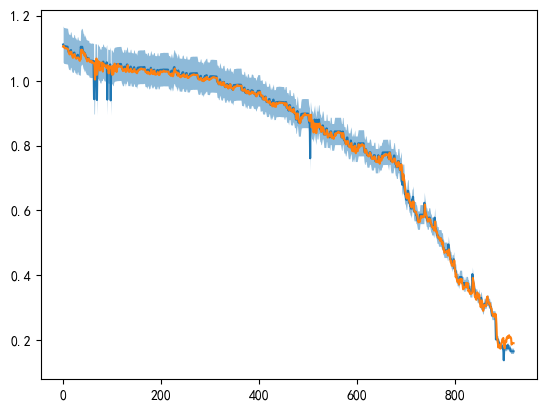

In [28]:
# b36为测试集合

train_dataset = BatteryDataset(b35 + b37 + b38)
test_dataset = BatteryDataset(b36)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("训练开始")
for epoch in range(epochs):
    train(model, train_dataloader, criterion, optimizer, epoch)
print("训练完成")

y_pred, gt, y1, y2 = [], [], [], []
cycle = [i + 1 for i in range(len(test_dataset))]
model.eval()
for idx, (X, y) in enumerate(test_dataset):
    X = X.to(device)
    y_pred.append(float(model(X)))
    gt.append(y)
    y1.append(y * (1 + 0.05))
    y2.append(y * (1 - 0.05))

plt.plot(gt)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(y_pred)

训练开始
训练完成


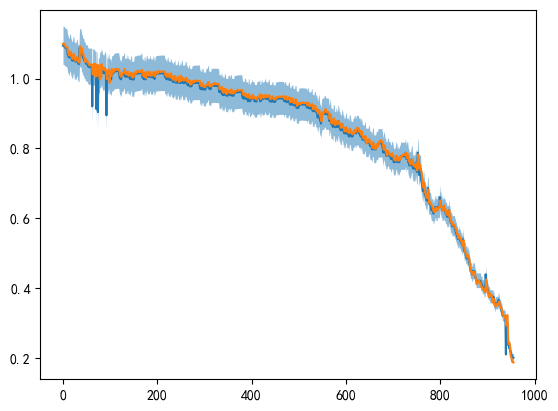

In [29]:
# b37为测试集合

train_dataset = BatteryDataset(b35 + b36 + b38)
test_dataset = BatteryDataset(b37)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("训练开始")
for epoch in range(epochs):
    train(model, train_dataloader, criterion, optimizer, epoch)
print("训练完成")

y_pred, gt, y1, y2 = [], [], [], []
cycle = [i + 1 for i in range(len(test_dataset))]
model.eval()
for idx, (X, y) in enumerate(test_dataset):
    X = X.to(device)
    y_pred.append(float(model(X)))
    gt.append(y)
    y1.append(y * (1 + 0.05))
    y2.append(y * (1 - 0.05))

plt.plot(gt)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(y_pred)

训练开始
训练完成


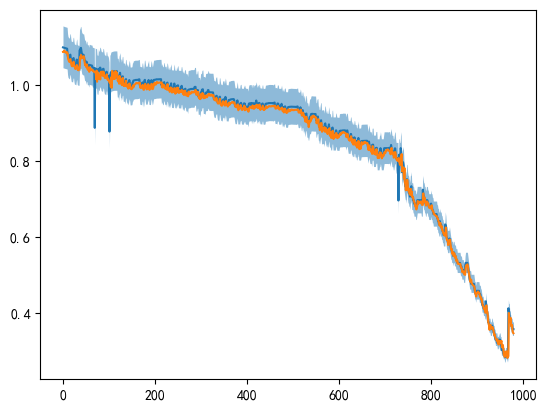

In [30]:
# b38为测试集合

train_dataset = BatteryDataset(b35 + b36 + b37)
test_dataset = BatteryDataset(b38)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("训练开始")
for epoch in range(epochs):
    train(model, train_dataloader, criterion, optimizer, epoch)
print("训练完成")

y_pred, gt, y1, y2 = [], [], [], []
cycle = [i + 1 for i in range(len(test_dataset))]
model.eval()
for idx, (X, y) in enumerate(test_dataset):
    X = X.to(device)
    y_pred.append(float(model(X)))
    gt.append(y)
    y1.append(y * (1 + 0.05))
    y2.append(y * (1 - 0.05))

plt.plot(gt)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(y_pred)